### Continent specific crown area allometries 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

import modp as mp

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_trop = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')
df_trop = df_trop.dropna(subset=['crown_area','dbh'])
df_trop_orig = df_trop

### Crown area allometry

In [3]:
def d2ca (d, p1, p2) :
    ca = p1 * d ** p2
    return ca

initial_guess = [0.7, 1.3]    

In [4]:
def fit_d2ca (df, initial_guess) :
    # remove nas  in dbh and CA
    df = df.dropna(subset=['crown_area','dbh'])
    # remove outliers
    df  = df[df['crown_radius_outlier']=='N']
   
    ca_ps, ca_cov = curve_fit(f=d2ca, xdata=np.array(df['dbh']), ydata=np.array(df['crown_area']),
                                           p0=initial_guess)

    return ca_ps #, ca_cov

### Filter by three realms 

In [5]:
df_trop = df_trop.loc[df_trop['realm'].isin(['Afrotropic','Indo-Malaya','Neotropic'])]

In [6]:
df_trop = df_trop.drop(df_trop[(df_trop.dbh < 50) & (df_trop.crown_area > 500) & (df_trop.realm == 'Indo-Malaya')].index)

### Filter  by biome 

In [7]:
df_rf = df_trop.loc[df_trop['biome'] == 'Tropical rain forest']
realms_rf = df_rf.realm.unique()
df_df = df_trop.loc[df_trop['biome'] == 'Tropical dry forest']
realms_df = df_df.realm.unique()
df_s = df_trop.loc[df_trop['biome'] == 'Tropical savanna']
realms_s = df_s.realm.unique()

In [8]:
df_s.groupby('realm').size()

realm
Afrotropic    5275
Neotropic      179
dtype: int64

In [9]:
df_rf.groupby('realm').size()

realm
Afrotropic      5597
Indo-Malaya    37328
Neotropic      17227
dtype: int64

## Final parameters

- Indo-Malaya - dipterocarps for everggreen PFT and dry forests hydro-deciduous PFT
- Neo-tropics - all rain forest species for evergreen PFT, and dry forest for hydro-deciduous PFT
- Afrotropics - all rain forest species for evergreen PFT and savanna for hydro-deciduous PFT

In [10]:
initial_guess = [0.7, 1.3]    
ds = np.arange(1, 250, 1)

### Asia

#### Evergreen - Dipterocarpaceae

In [11]:
df_rf_asia = df_rf.loc[df_rf['realm'] == 'Indo-Malaya']
df_rf_asia = df_rf_asia.loc[df_rf_asia['family'] == 'Dipterocarpaceae']
rf_asia_ps = fit_d2ca(df_rf_asia, initial_guess)
curve_rf_asia = [d2ca(d, rf_asia_ps[0], rf_asia_ps[1])  for  d  in ds]

### Americas

#### Evergreen - rain forests

In [12]:
df_rf_americas = df_rf.loc[df_rf['realm'] == 'Neotropic']
rf_americas_ps = fit_d2ca(df_rf_americas, initial_guess)
curve_rf_americas = [d2ca(d, rf_americas_ps[0], rf_americas_ps[1])  for  d  in ds]

#### Hydro-deciduous - dry forests

In [13]:
df_df_americas = df_df.loc[df_df['realm'] == 'Neotropic']
df_americas_ps = fit_d2ca(df_df_americas, initial_guess)
curve_df_americas = [d2ca(d, df_americas_ps[0], df_americas_ps[1])  for  d  in ds]

### Africa

#### Evergreen - rain forest

In [14]:
df_rf_africa = df_rf.loc[df_rf['realm'] == 'Afrotropic']
rf_africa_ps = fit_d2ca(df_rf_africa, initial_guess)
curve_rf_africa = [d2ca(d, rf_africa_ps[0], rf_africa_ps[1])  for  d  in ds]

#### Hydro-deciduos - savanna

In [15]:
df_s_africa = df_s.loc[df_s['realm'] == 'Afrotropic']
s_africa_ps = fit_d2ca(df_s_africa, initial_guess)
curve_s_africa = [d2ca(d, s_africa_ps[0], s_africa_ps[1])  for  d  in ds]

Text(0.02, 0.5, 'Crown area (m2)')

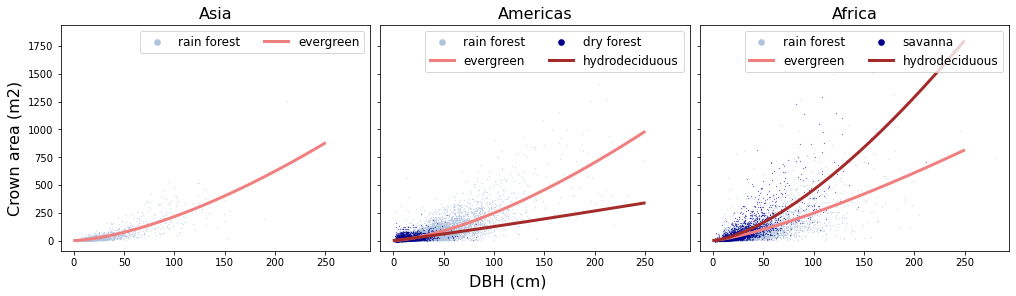

In [16]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(df_rf_asia['dbh'], df_rf_asia['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(df_rf_americas['dbh'], df_rf_americas['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_df_americas['dbh'], df_df_americas['crown_area'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)

axs[2].scatter(df_rf_africa['dbh'], df_rf_africa['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(df_s_africa['dbh'], df_s_africa['crown_area'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)



### Save the parameter values!

In [17]:
ca_continent_ps = pd.DataFrame(rf_americas_ps, columns=['American_rf'])
ca_continent_ps['African_rf'] = rf_africa_ps
ca_continent_ps['Asian_rf'] = rf_asia_ps
ca_continent_ps['American_df'] = df_americas_ps
ca_continent_ps['African_s'] = s_africa_ps


In [18]:
ca_continent_ps.head(3)

,American_rf,African_rf,Asian_rf,American_df,African_s
0,0.245674,0.608674,0.184460,0.855484,0.461061
1,1.501869,1.303720,1.533768,1.083191,1.497704


In [19]:
ca_continent_ps.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/ca_continent_ps.csv', index=False)

### Add in the current allometry

In [20]:
global_ca = [d2ca(d, 0.2715891, 1.6019679)  for  d  in ds]

Text(0.02, 0.5, 'Crown area (m2)')

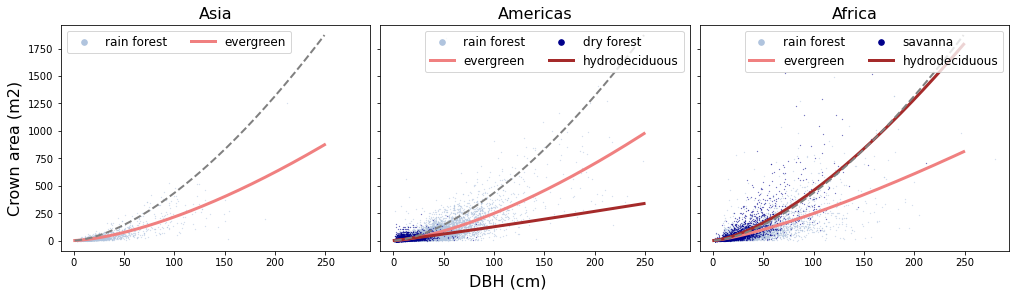

In [21]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(df_rf_asia['dbh'], df_rf_asia['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)
axs[0].plot(ds, global_ca, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


axs[1].scatter(df_rf_americas['dbh'], df_rf_americas['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_df_americas['dbh'], df_df_americas['crown_area'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)
axs[1].plot(ds, global_ca, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


axs[2].scatter(df_rf_africa['dbh'], df_rf_africa['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(df_s_africa['dbh'], df_s_africa['crown_area'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)
axs[2].plot(ds, global_ca, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)

## Pantropical allometry 

In [22]:
df_trop = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')
df_trop = df_trop.dropna(subset=['crown_area','dbh'])
df_trop_orig = df_trop

In [23]:
df_trop = df_trop.loc[df_trop['realm'].isin(['Afrotropic','Indo-Malaya','Neotropic'])]

In [24]:
df_trop = df_trop.drop(df_trop[(df_trop.dbh < 50) & (df_trop.crown_area > 500) & (df_trop.realm == 'Indo-Malaya')].index)

### Filter  by biome 

In [25]:
df_rf = df_trop.loc[df_trop['biome'] == 'Tropical rain forest']
realms_rf = df_rf.realm.unique()

df_df = df_trop.loc[df_trop['biome'] == 'Tropical dry forest']
realms_df = df_df.realm.unique()

df_s = df_trop.loc[df_trop['biome'] == 'Tropical savanna']
realms_s = df_s.realm.unique()

df_dfs = df_trop.loc[df_trop['biome'].isin(['Tropical dry forest','Tropical savanna'])]

In [26]:
ca_ps_rf = fit_d2ca(df_rf, initial_guess) 
ca_ps_df = fit_d2ca(df_df, initial_guess)
ca_ps_s = fit_d2ca(df_s, initial_guess)

ca_ps_dfs = fit_d2ca(df_dfs,  initial_guess)

In [27]:
print(ca_ps_rf)
print(ca_ps_dfs)

[0.22267948 1.51492794]
[0.28895957 1.59335073]


In [28]:
curve_rf = [d2ca(d, ca_ps_rf[0], ca_ps_rf[1])  for  d  in ds]
curve_df = [d2ca(d, ca_ps_df[0], ca_ps_df[1])  for  d  in ds]
curve_s = [d2ca(d, ca_ps_s[0], ca_ps_s[1])  for  d  in ds]
curve_dfs = [d2ca(d, ca_ps_dfs[0], ca_ps_dfs[1])  for d in ds]

#### Separate dry forest and savanna

Text(0.02, 0.5, 'Crown area (m2)')

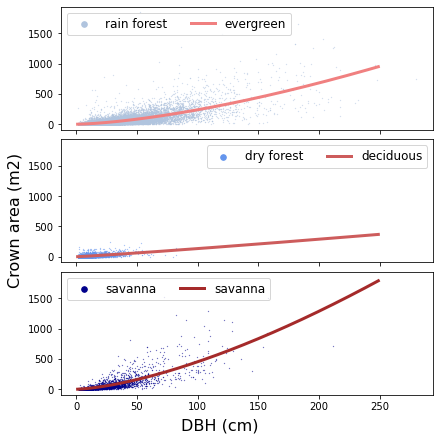

In [29]:
fig1, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)

axs = axs.flatten()

axs[0].scatter(df_rf['dbh'], df_rf['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)

axs[1].scatter(df_df['dbh'], df_df['crown_area'], s=0.05, color='cornflowerblue', label = 'dry forest')
axs[1].plot(ds, curve_df, color='indianred',label='deciduous',linewidth=3.0)

axs[2].scatter(df_s['dbh'], df_s['crown_area'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s, color='brown',label='savanna',linewidth=3.0)


axs[0].legend(fontsize=12, ncol=3, markerscale=25)
axs[1].legend(fontsize=12, ncol=3, markerscale=25)
axs[2].legend(fontsize=12, ncol=3, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)



#### Just evergreen v deciduous

Text(0.02, 0.5, 'Crown area (m2)')

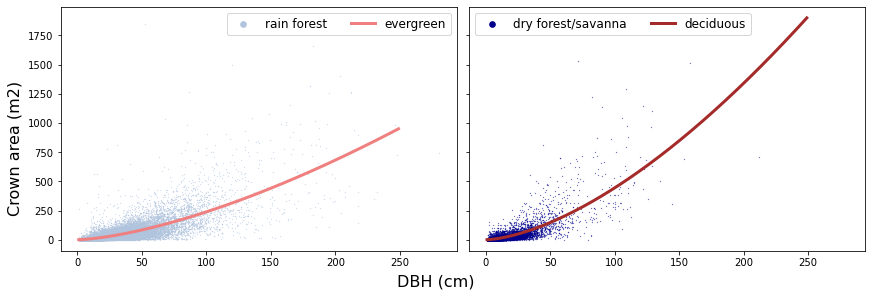

In [30]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=True, sharey=True, constrained_layout=True)

axs = axs.flatten()

axs[0].scatter(df_rf['dbh'], df_rf['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)

axs[1].scatter(df_dfs['dbh'], df_dfs['crown_area'], s=0.05, color='darkblue', label = 'dry forest/savanna')
axs[1].plot(ds, curve_dfs, color='brown',label='deciduous',linewidth=3.0)

axs[0].legend(fontsize=12, ncol=3, markerscale=25)
axs[1].legend(fontsize=12, ncol=3, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)

In [31]:
ca_pantropical_ps = pd.DataFrame(ca_ps_rf, columns=['rainforest'])
ca_pantropical_ps['dry_savanna'] = ca_ps_dfs


In [32]:
ca_pantropical_ps.head(3)

,rainforest,dry_savanna
0,0.222679,0.288960
1,1.514928,1.593351


In [33]:
ca_pantropical_ps.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/ca_pantropical_ps.csv', index=False)